In [ ]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime as dt
from pandas.tseries.offsets import BDay
from scipy.linalg import pinv2
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
from functools import partial
import gc
import time
import matplotlib.pyplot as plt 
import cufflinks as cf
cf.go_offline()

In [ ]:
import yfinance as yf

In [ ]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 30)

In [ ]:
def winsorize(data, quantile=0.01, axis=1):
    """ aim to deal with outlier in distribution.
    axis=1 for XS
    axis=0 fot TS
    """
    
    quantiles = data.quantile(q=[quantile, 1-quantile], axis=axis)
    
    return data.clip(
        lower=quantiles.iloc[0].dropna(),
        upper=quantiles.iloc[1].dropna(),
        axis=0 if axis==1 else 1,
    )

### get data

In [ ]:
# import the list of stocks which is saved to csv
instrs = pd.read_csv('G:/sp100.csv', header=None)
instrs = ' '.join(list(instrs[0].values))
instrs

In [ ]:
data = yf.download(instrs, start="2015-01-01", end="2021-12-31")
data.sample(10)

###### will need to check why BRK.B failed, but skip to save time

In [ ]:
data.notnull().sum(axis=1, level=0).iplot(title='some data is missing, and skip the data check for 2016 drop to save time')

In [ ]:
# # didn't find way to get daily update on marketcap, let's use the fixed one and use for whole sample
# dict_marketcap = dict()
# for stock in instrs.split(' '): 
#     dict_marketcap[stock] = yf.Ticker(stock).info['marketCap'] 
# dict_marketcap = pd.Series(dict_marketcap)

#### I download marketcap in another notebook and import here as it's too slow to download

In [ ]:
dict_marketcap = pd.read_csv('G:/marketcap.csv', header=None)
dict_marketcap

In [ ]:
data = data.stack()
data.index.names = ['date','stock_id']

In [ ]:
data

In [ ]:
data = data.reset_index().merge(
    dict_marketcap.rename(columns={0:'stock_id', 1:'marketcap'}), on='stock_id', how='left')
data = data.set_index(['date','stock_id']).unstack()

In [ ]:
data.notnull().sum(axis=1, level=0).iplot(title='some data is missing but skip the data check to save time')

In [ ]:
data.columns.levels[0]

### clean data

####  describe, ditribution, in case of outlier

In [ ]:
data.stack().describe()

In [ ]:
data.stack().hist(bins=100, figsize=(16,9))

In [ ]:
ret = data['Adj Close'].diff() / data['Adj Close'].shift(1)
# assume volume is not adjusted
turnover_ratio = ((data['Volume']*data['Close']) / data['marketcap']).clip(0, 1) 

In [ ]:
ret.stack().hist(bins=100)

In [ ]:
# winsor ret, can be used in portfolio analysis, to see if the performance is driven by outlier
ret_winsor = winsorize(ret)
ret_winsor.stack().hist(bins=100)

In [ ]:
turnover_ratio.stack().hist(bins=100)

In [ ]:
# prepare data to use
data_used = {'ret':ret, 'ret_winsor': ret_winsor,'adjPrice': data['Adj Close'], 'turnover': turnover_ratio}

In [ ]:
pd.concat(
    data_used, axis=1
).notnull().sum(axis=1, level=0).iplot(title='some data is missing but skip the data check to save time')

### score definition
    Motivation: 
    due to disposition effect, investors like to hold stocks they lose but close their postions too early when they gain
 
    Reference:
    https://www.nber.org/system/files/working_papers/w8734/w8734.pdf
    
    We can measure investors' reference price as equation (25) in the paper.
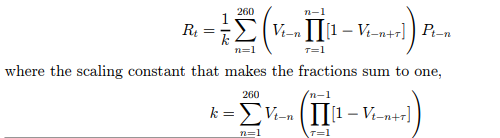
    the multiplier of price can be interpreted as the probablity that one share is traded at day t-n but not traded after that. In that sense, the reference price is a weighted averaged past price.
    And the score is defined as:
    
    score = 1 - reference_price / price
    
    e.g., when current price is higher than reference_price, the irrational guys sell too early and price can still go up. Thus, we want to buy

In [ ]:
class Disposition():
    
    def __init__(self, window, smooth):
        """param explain
        """
        self.window = window
        self.smooth = smooth
        
#         assert parameters ''
        
    def compute(self, data):
        
        turnover = data['turnover'] # can do some winsorize on turnover ratio
        price = data['adjPrice']
        
        tur_price = turnover * price
        one_minus_tur = (1 - turnover).fillna(1)
        
        reference_price = tur_price.copy()
        one_minus_tur_prod = one_minus_tur.copy()
        denorm = turnover
        for i in range(1, self.window+1):
            reference_price = reference_price.add(
                one_minus_tur_prod * tur_price.shift(i), fill_value=0
            )
            denorm = denorm.add(
                one_minus_tur_prod * turnover.shift(i), fill_value=0
            )
            one_minus_tur_prod *= one_minus_tur.shift(i)
            
        reference_price = reference_price / denorm

        score = 1 - reference_price / price
        
        if self.smooth > 0:
            score = score.ewm(self.smooth).mean()
            
        return score

In [ ]:
score = Disposition(window=252, smooth=0).compute(data=data_used)

### score analysis

In [ ]:
score.stack().describe()

In [ ]:
score.stack().hist(bins=100)

In [ ]:
score_winsored = winsorize(score)

In [ ]:
score_winsored.stack().hist(bins=100)

### as the strategy is cross sectional long/short, we normalize the score

In [ ]:
def normalize_rank(score):
    
    score = score.rank(axis=1)
    score = score.subtract(score.min(axis=1), axis='index')
    score = score.div(score.max(axis=1) - score.min(axis=1), axis='index')
    # demean to be long short
    score = score - 0.5
    
    return score

In [ ]:
norm_score = normalize_rank(score_winsored)

In [ ]:
norm_score.stack().hist(bins=100)

 ### first look at the score vs forward (averaged return)
    ideally, we want to look at the benchmark adjusted returns for a benchmark neutral strategy

In [ ]:
def compute_score_vs_forward_returns(score, forward_returns, number_quantiles):
    
    forward_returns = forward_returns.reindex(score.index)
    
    horizons = list(np.sort(forward_returns.columns.get_level_values('horizon').unique()))
    
    df = {h: forward_returns[h] for h in horizons}
    df['score'] = score
    
    df = pd.concat(df, axis=1).stack()
    
    # 
    bins = pd.qcut(df['score'].values, number_quantiles)
    df['score_bin'] = bins.codes
    
    df = df.mask(df['score_bin'] < 0)
    df['score_median'] = df.groupby('score_bin')['score'].transform(np.median)
    
    df = df.groupby('score_median')[horizons].mean()
    return df

In [ ]:
forward_returns = pd.concat({w: winsorize(ret).rolling(w, w//2).mean() for w in [5, 10, 21, 63]}, axis=1)
forward_returns.columns.names = ['horizon','stock_id']

In [ ]:
score_vs_forward_returns = compute_score_vs_forward_returns(norm_score, forward_returns, number_quantiles=10)
score_vs_forward_returns.iplot(title='score vs forward return')

In [ ]:
### can do more: score residualization on size, beta, sector dummies ....

### portfolio construction

###### first, we can simpply use the score as portfolio weights and scale the portfolio according to volaility

In [ ]:
def simple_optimizer(score, ret):
    
    weights = score.copy()
    
    # each end of day, scale the weights according to short-term vol
    pnl = (score.reindex_like(ret).shift(1) * ret).sum(axis=1)
    # let say we want to 10% target vol
    scaling = (
        0.1 / (np.sqrt(252) * pnl.rolling(63, int(63/2)).std().replace(0,np.nan)))
    
    return score.mul(scaling, axis=0)

In [ ]:
weights = simple_optimizer(norm_score, ret)

In [ ]:
weights.stack().hist(bins=100)

### portfolio analysis

In [ ]:
def compute_stats(weights, ret):
    pnl = (weights.shift(1) * ret).sum(axis=1)

    mean = pnl.mean()
    std = pnl.std()
    df_level = 100 * (1+pnl).cumprod()
    
    deviated_weight = (weights.shift() * (1+ ret)).div((1+ pnl), axis=0)
    leverage = weights.abs().sum(axis=1)
    
    turnover = (weights - deviated_weight).abs().div(leverage, axis=0).sum(axis=1).mean() * 252
    
    return pnl, pd.Series({
        'sharpe': np.sqrt(252) * mean / std,
        'sharpe_1y': np.sqrt(252) * pnl.tail(252).mean() / pnl.tail(252).std(),
        'sharpe_3y': np.sqrt(252) * pnl.tail(3*252).mean() / pnl.tail(3*252).std(),
        'alpha': 252 * mean,
        'stdev': np.sqrt(252) * std,
        'tur/leverage': turnover,
        'skew': pnl.skew(),
        'wDD_5d': (df_level / df_level.shift(5) -1).min() /std/np.sqrt(252),
        'wDD_22d': (df_level / df_level.shift(22) -1).min() /std/np.sqrt(252),
        'wDD_all': (df_level / df_level.expanding().max() -1).min() /std/np.sqrt(252),
    }).reindex(
        ['sharpe','sharpe_1y','sharpe_3y','alpha','stdev','tur/leverage','skew','wDD_5d','wDD_22d','wDD_all'])

In [ ]:
dict_stats = dict()
dict_pnl = dict()
# check the performance with different lag (or smoothing) on the score
for lag in [0, 3, 5, 10, 21, 63]:
    _weight = simple_optimizer(norm_score.shift(lag), ret)
    dict_pnl['lag%s'%lag], dict_stats['lag%s'%lag] = compute_stats(_weight, ret)

In [ ]:
dict_pnl = pd.concat(dict_pnl, axis=1)
dict_stats = pd.concat(dict_stats, axis=1).T

dict_pnl.cumsum().iplot(title='performance at various lag')
display(dict_stats.round(2))

In [ ]:
sharp_decay = dict_stats.reset_index()
sharp_decay['lag'] = sharp_decay['index'].apply(lambda x: int(x.split('lag')[1]))

In [ ]:
sharp_decay.set_index('lag')[['sharpe','sharpe_3y']].iplot(title='sharpe at different lags')

## as the simple optimizer can not add constraint, we can use cvxpy to do a bit more

### first, can do a little toy risk model, benchmark as simple averaged one

In [ ]:
benchmark = ret.notnull().div(ret.notnull().sum(axis=1), axis=0)
benchmark

In [ ]:
# daily covariance
covariance = (
    ret.ewm(halflife=126, min_periods=63, adjust=True, ignore_na=True).cov()
)

##### risk model based on covariance
    to save time, let me focus post 2020

In [ ]:
days = ret.loc['2020':].index
days

In [ ]:
def get_risk_model(date):
    
    dt_weight = benchmark.loc[date].fillna(0) 
    instr = dt_weight.index
    
    dt_cov = covariance.loc[date,].reindex(index=instr, columns=instr)
    
    # beta
    dt_beta = (
        dt_cov.dot(dt_weight) /
        dt_weight.dot(dt_cov.fillna(0)).dot(dt_weight)
    )
    
    dt_var = pd.Series(np.diagonal(dt_cov), index=dt_cov.index)
    
    dt_cov = dt_cov.stack()
    dt_cov.index.names = ['stock_id1','stock_id2']
    
    return date, dt_cov, dt_beta, dt_var

In [ ]:
dict_beta = {}
dict_cov = {}
dict_var = {}
for day in days:
    _, dt_cov, dt_beta, dt_var = get_risk_model(day)
    dict_beta[day] = dt_beta
    dict_cov[day] = dt_cov
    dict_var[day] = dt_var

In [ ]:
df_beta = pd.concat(dict_beta, axis=1).T.dropna(how='all')
df_var = pd.concat(dict_var, axis=1).T.dropna(how='all')

In [ ]:
df_beta.mean(axis=1).iplot(title='average beta should be round 1')

In [ ]:
df_var.notnull().sum(axis=1).iplot()

In [ ]:
risk_model = {}
risk_model['beta'] = df_beta.reindex(
    index=pd.bdate_range(df_beta.index.min(), df_beta.index.max())).ffill(limit=63).reindex_like(ret).fillna(0)
risk_model['volatility'] = np.sqrt(df_var).reindex(
    index=pd.bdate_range(df_var.index.min(), df_var.index.max())).ffill(limit=63).reindex_like(ret)
risk_model['covariance'] = {
    day: cov.unstack('stock_id2').reindex(
        index=risk_model['beta'].loc[day].index, columns=risk_model['beta'].loc[day].index).fillna(0) 
    for day, cov in dict_cov.items()
}

In [ ]:
risk_model['beta']

In [ ]:
risk_model['volatility']

In [ ]:
risk_model['covariance'][list(risk_model['covariance'].keys())[10]]

In [ ]:
# get a sense of market vol
(risk_model['volatility']**2 * 252).mean(axis=1).iplot()

### Second, optimizer with cvxpy

In [ ]:
import cvxpy as cvx

In [ ]:
def solver(n, mu, dt_beta, dt_cov,
           min_dollar, max_dollar,
           min_beta, max_beta, 
           min_weights, max_weights, leverage, target_vol):
    
    w = cvx.Variable(n)

    ret = cvx.sum(cvx.multiply(mu, w))
    vol = cvx.quad_form(w, dt_cov)
    beta = cvx.sum(cvx.multiply(dt_beta, w))
    

    objective = cvx.Maximize(ret)
    constraints = [cvx.sum(w) <= max_dollar, cvx.sum(w) >= min_dollar, 
                   min_beta<=beta, beta<= max_beta,
                   cvx.sum(cvx.abs(w)) <= leverage, 
                   cvx.max(w) <= max_weights, cvx.min(w) >= min_weights, 
                   vol * 252 <= target_vol]
    prob = cvx.Problem(objective, constraints)
    
    prob.solve(verbose=False)
    
    return w.value


def cvxpy_optimizer(score, days, df_beta, df_cov, target_vol=0.1, 
                    max_dollar=0.05, min_dollar=-0.05,
                    max_beta=0.1, min_beta=-0.1, 
                    min_weights=-0.1, max_weights=0.1, leverage=3):
    
    dict_weights = {}
    
    for day in days:
        
        instr = ret.notnull().loc[day]
        instr = instr[instr].index
        # naively fillna(0), in practice need to check more
        mu = score.loc[day, instr].reindex(instr).fillna(0).values
        dt_beta = df_beta.loc[day, instr].reindex(instr).fillna(0).values
        dt_cov = df_cov[day].reindex(index=instr, columns=instr).fillna(0).values
        
        try:
            weights = solver(len(instr), mu, dt_beta, dt_cov,
                             min_dollar, max_dollar,
                             min_beta, max_beta, min_weights, max_weights, leverage, target_vol)
            dict_weights[day] = pd.Series(weights, index=instr)
        except:
            print('fail on %s'%day)
            
    return dict_weights

In [ ]:
weight_cvxpy = cvxpy_optimizer(
    score=norm_score, days=days, df_beta=risk_model['beta'], df_cov=risk_model['covariance'])
weight_cvxpy = pd.concat(weight_cvxpy, axis=1).T.reindex_like(ret).loc['2020':]

In [ ]:
weight_cvxpy.stack().hist(bins=100)

### lots of days the optimizer fails to converge 
    Here ths issue can be mostly in the covaraince matrix.
    In practice if we have a good and stable cov, we can relax a bit the constrains and redo the optimizer
    Here, I will just do the filering and ffill the correct position in this test

In [ ]:
weight_cvxpy.count(axis=1).iplot()

In [ ]:
### check postions
weight_cvxpy.sum(axis=1).iplot(title='net dollar exposure')
weight_cvxpy.abs().sum(axis=1).iplot(title='gross dollar exposure, leverage')
pd.concat({'max':weight_cvxpy.max(axis=1),'min':weight_cvxpy.min(axis=1),}, axis=1).iplot(title='max and min')

In [ ]:
weight_cvxpy = weight_cvxpy.reindex_like(ret).loc['2020':].ffill()

In [ ]:
weight_cvxpy

In [ ]:
dict_stats = dict()
dict_pnl = dict()
# check the performance with different lag (or smoothing) on the score
for lag in [0, 3, 5, 10, 21]:
    dict_pnl['lag%s'%lag], dict_stats['lag%s'%lag] = compute_stats(weight_cvxpy.shift(lag), ret.loc['2020':])

In [ ]:
dict_pnl = pd.concat(dict_pnl, axis=1)
dict_stats = pd.concat(dict_stats, axis=1).T

dict_pnl.cumsum().iplot(title='performance at various lag')
display(dict_stats.round(2))

In [ ]:
### you can see a big difference between the realized stdev and target vol, this is due to the covaraince matrix estimation

### furthur more, can introduce the turnover in to objective function or add turnover, min_trade constraint
    turnover = (optimized_weights - current_position).abs().sum(axis=1)
    
    and thus objective function becomes: 
    
    objective = cvx.Maximize(ret - lambda * turnover)
    
    and need to calibrate lambda in practice to look at the trade of net performance vs turnover over different lambdas